In [5]:
import numpy as np
import tensorflow
from tensorflow import keras
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.layers import concatenate,AveragePooling2D
import os
print(os.listdir("/Users/vamshikrishna/Downloads/blood-cells"))
import cv2
import scipy
import scipy.misc
from skimage import data
from skimage.transform import resize
from PIL import Image
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Dropout, MaxPool2D, Input, Softmax, Activation, Flatten


['dataset-master', 'dataset2-master']


In [4]:
from tqdm import tqdm
#tqdm is used to get progress bar to show the progress of a procedure

from tensorflow.keras import backend
#model-level library,providing high level building blocks for developing deep learning models

def get_data(folder):
#this is user defined function

    A = []
    B = []
    C = []
    #defining arrays here
    
    for wbc_type in os.listdir(folder): #os.listdir(path) gives all te files and directories in the specified directory
        
        if not wbc_type.startswith('.'): #gives 1 when wbctype does not start with '.' and enters the loop
            
            if wbc_type in ['NEUTROPHIL']:
                label = 1
                label2 = 1
            elif wbc_type in ['EOSINOPHIL']:
                label = 2
                label2 = 1
            elif wbc_type in ['MONOCYTE']:
                label = 3  
                label2 = 0
            elif wbc_type in ['LYMPHOCYTE']:
                label = 4 
                label2 = 0
            else:
                label = 5
                label2 = 0
#label gives the overall type and label2 gives either mononuclear or polynuclear depending upon its value

                
            for image_filename in tqdm(os.listdir(folder + wbc_type)):
            #gets into the folder and inside folder of wbc_type
            
                img_file = cv2.imread(folder + wbc_type + '/' + image_filename)
                #cv2.imread(path,flag), flag is about color
                
                if img_file is not None: 
                    img_file = resize(img_file,(60,80,3)) #resize is used to resize the img
                    img_arr = np.asarray(img_file) #converts the img into array 
                    A.append(img_arr)  #appends the array image to A
                    B.append(label) 
                    C.append(label2)
    A = np.asarray(A) #converting the total images into arrays
    B = np.asarray(B) #label to array
    C = np.asarray(C) #label2 to array
    return A,B,C
X_train, y_train, z_train = get_data('/Users/vamshikrishna/Downloads/blood-cells/dataset2-master/dataset2-master/images/TRAIN/')
#training data-set 
X_test, y_test, z_test = get_data('/Users/vamshikrishna/Downloads/blood-cells/dataset2-master/dataset2-master/images/TEST/')
#testing data-set

# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
from keras.utils.np_utils import to_categorical
y_trainHot = to_categorical(y_train, num_classes = 5)# to_categorical the given array into matrix 
#keras.utils.to_categorically(y,num_classes,dtype)-is its general syntax

y_testHot = to_categorical(y_test, num_classes = 5) #it has 5 different types so  num_classes=5
z_trainHot = to_categorical(z_train, num_classes = 2)
z_testHot = to_categorical(z_test, num_classes = 2)
dict_characters = {1:'NEUTROPHIL',2:'EOSINOPHIL',3:'MONOCYTE',4:'LYMPHOCYTE'}
dict_characters2 = {0:'Mononuclear',1:'Polynuclear'}
print(dict_characters)
print(dict_characters2)

100%|██████████| 620/620 [00:06<00:00, 94.61it/s]


{1: 'NEUTROPHIL', 2: 'EOSINOPHIL', 3: 'MONOCYTE', 4: 'LYMPHOCYTE'}
{0: 'Mononuclear', 1: 'Polynuclear'}


In [6]:
print("Train X Shape: ",X_train.shape)
print("Train y Shape: ",y_trainHot.shape)
print("train z shape:",z_trainHot.shape)



Train X Shape:  (9957, 60, 80, 3)
Train y Shape:  (9957, 5)
train z shape: (9957, 2)


In [6]:
def keras_model(block_num=2):
    inp = Input(shape=(60,80,3))
    #taking the input
    k = BatchNormalization()(inp)
    k = Conv2D(32, (7,7), padding="same",activation="relu",strides=(2,2))(k)
    #32 is the number of filters,(7,7) is the kernel_size/filter size
    #padding is vaild(same),strides(steps)
    k = MaxPool2D(pool_size=(3, 3), padding="same",strides=(2,2))(k) 
    k = Conv2D(32, (3,3), padding="same",activation="relu",strides=(1,1))(k)
    k = MaxPool2D(pool_size=(3, 3), padding="same",strides=(2,2))(k)
    for j in range(1,block_num+1):
        out_conv = []
        for i in [(1,1),(3,3),(5,5),(0,0)]:
            p = k
            if i == (1,1):
                p = Conv2D(32, (1,1), padding="same",activation="relu")(p)
                out_conv.append(Conv2D(32, (1,1), padding="same",activation="relu")(p))
            elif i == (0,0):
                p = MaxPool2D(pool_size=(2, 2), padding="same",strides=(1,1))(p)
                out_conv.append(Conv2D(32, (1,1), padding="same",activation="relu")(p))
            else:
                p = Conv2D(32, (1,1), padding="same",activation="relu")(p)
                p = Conv2D(32, i, padding="same",activation="relu")(p)
                out_conv.append(Conv2D(32, i, padding="same",activation="relu")(p))
        x = concatenate(out_conv, axis = -1)
        #if j%2 == 0:
        #    x = MaxPool2D(pool_size=(3, 3), padding="same",strides=(2,2))(x)
        #x = BatchNormalization(axis=-1)(x)
        k = x
   # x = Dropout(0.5)(k)
    x = MaxPool2D(pool_size=(7, 7), padding="same",strides=(2,2))(x)
    x = Flatten()(x)
    #x = Dense(1024,activation="relu")(x)
    #x = BatchNormalization()(x)
    #x = Dropout(0.5)(x)
    B = Dense(5,activation="softmax")(x)
#    z = Dense(2,activation="softmax")(x)
    model = Model(inp, B)
    opt = optimizers.Adam(lr=0.01,decay=0.0001)
    model.compile(loss='categorical_crossentropy',
                  optimizer="adam",
                  metrics=['accuracy'])
    return model
model = keras_model(4)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 60, 80, 3)    0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 60, 80, 3)    12          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 30, 40, 32)   4736        batch_normalization[0][0]        
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 15, 20, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (

In [7]:
filepath = "./weight_tr5.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
history = model.fit(X_train,
         y_trainHot,
         epochs = 40,
         batch_size = 32,
         validation_data = (X_test,y_testHot),
         callbacks = callbacks_list,
         verbose = 1)

Train on 9957 samples, validate on 2487 samples
Epoch 1/40
9957/9957 [==============================] - 97s 10ms/step - loss: 1.2755 - acc: 0.3357 - val_loss: 0.9681 - val_acc: 0.4942

Epoch 00001: val_acc improved from -inf to 0.49417, saving model to ./weight_tr5.hdf5
Epoch 2/40
9957/9957 [==============================] - 93s 9ms/step - loss: 0.7038 - acc: 0.6589 - val_loss: 0.5372 - val_acc: 0.7016

Epoch 00002: val_acc improved from 0.49417 to 0.70165, saving model to ./weight_tr5.hdf5
Epoch 3/40
9957/9957 [==============================] - 141s 14ms/step - loss: 0.4384 - acc: 0.8123 - val_loss: 0.3885 - val_acc: 0.7833

Epoch 00003: val_acc improved from 0.70165 to 0.78327, saving model to ./weight_tr5.hdf5
Epoch 4/40
9957/9957 [==============================] - 95s 10ms/step - loss: 0.2891 - acc: 0.8763 - val_loss: 0.3846 - val_acc: 0.8267

Epoch 00004: val_acc improved from 0.78327 to 0.82670, saving model to ./weight_tr5.hdf5
Epoch 5/40
9957/9957 [=============================

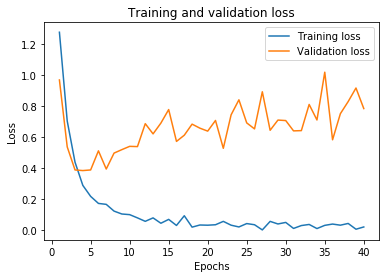

In [8]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
history_dict = history.history
history_dict.keys()
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()